# Protocol Selection of FedLeak (Resize Generator), ImageNet(ISLVRC2012)

Here is the protocol selection to decide in which way should FedLeak be transferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=False`.
- *Way to report*: best PSNRs in $5$ times recovery.

Codes are aligned with `sanity_check_resize_ImageNet.ipynb`, with two modifications utilized:
- ⭕ Force generating with $224\times224\times3$.
- ⭕ Abort comparing with `upsampling` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:2")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=2)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

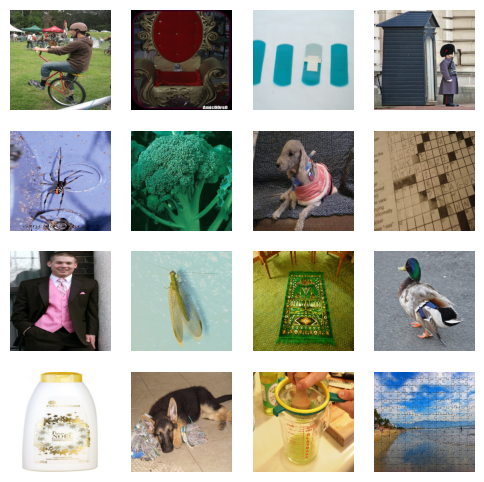

| It: 1 | Loss: -5.7232 | Time:   4.92s |


| It: 1001 | Loss: -60.8552 | Time: 505.42s |


| It: 2001 | Loss: -61.4112 | Time: 600.03s |


| It: 3001 | Loss: -61.5962 | Time: 601.44s |


| It: 4001 | Loss: -61.6851 | Time: 601.03s |


| It: 5001 | Loss: -61.7509 | Time: 603.93s |


| It: 6001 | Loss: -61.7931 | Time: 601.86s |


| It: 7001 | Loss: -61.8271 | Time: 604.66s |


| It: 8001 | Loss: -61.8480 | Time: 603.75s |


| It: 9001 | Loss: -61.8590 | Time: 599.96s |


| It: 1 | Loss: 2.4809 | Time:   0.68s |


| It: 1001 | Loss: -60.4891 | Time: 602.13s |


| It: 2001 | Loss: -61.1844 | Time: 601.94s |


| It: 3001 | Loss: -61.4695 | Time: 601.78s |


| It: 4001 | Loss: -61.6198 | Time: 600.41s |


| It: 5001 | Loss: -61.7018 | Time: 599.34s |


| It: 6001 | Loss: -61.7566 | Time: 602.54s |


| It: 7001 | Loss: -61.8003 | Time: 601.00s |


| It: 8001 | Loss: -61.8274 | Time: 600.95s |


| It: 9001 | Loss: -61.8403 | Time: 599.13s |


| It: 1 | Loss: -13.0504 | Time:   0.67s |


| It: 1001 | Loss: -60.4230 | Time: 600.04s |


| It: 2001 | Loss: -61.2382 | Time: 601.61s |


| It: 3001 | Loss: -61.5098 | Time: 599.23s |


| It: 4001 | Loss: -61.6373 | Time: 600.91s |


| It: 5001 | Loss: -61.7139 | Time: 601.20s |


| It: 6001 | Loss: -61.7683 | Time: 601.88s |


| It: 7001 | Loss: -61.8071 | Time: 602.09s |


| It: 8001 | Loss: -61.8314 | Time: 598.93s |


| It: 9001 | Loss: -61.8432 | Time: 597.02s |


| It: 1 | Loss: -16.1174 | Time:   0.66s |


| It: 1001 | Loss: -60.5474 | Time: 600.56s |


| It: 2001 | Loss: -61.2301 | Time: 598.12s |


| It: 3001 | Loss: -61.4458 | Time: 598.43s |


| It: 4001 | Loss: -61.6147 | Time: 601.68s |


| It: 5001 | Loss: -61.6933 | Time: 598.44s |


| It: 6001 | Loss: -61.7506 | Time: 602.49s |


| It: 7001 | Loss: -61.7910 | Time: 598.96s |


| It: 8001 | Loss: -61.8182 | Time: 601.72s |


| It: 9001 | Loss: -61.8311 | Time: 602.20s |


| It: 1 | Loss: -2.0223 | Time:   0.66s |


| It: 1001 | Loss: -60.4473 | Time: 589.95s |


| It: 2001 | Loss: -61.3098 | Time: 599.09s |


| It: 3001 | Loss: -61.5643 | Time: 598.55s |


| It: 4001 | Loss: -61.6629 | Time: 599.21s |


| It: 5001 | Loss: -61.7320 | Time: 594.35s |


| It: 6001 | Loss: -61.7862 | Time: 600.72s |


| It: 7001 | Loss: -61.8217 | Time: 600.67s |


| It: 8001 | Loss: -61.8439 | Time: 600.98s |


| It: 9001 | Loss: -61.8553 | Time: 601.85s |


BEST PSNR: 15.8945
MEDIAN PSNR: 15.3867
ALL PSNR: [15.7529, 15.7989, 15.8945, 14.5371, 14.5371]


<Figure size 400x300 with 0 Axes>

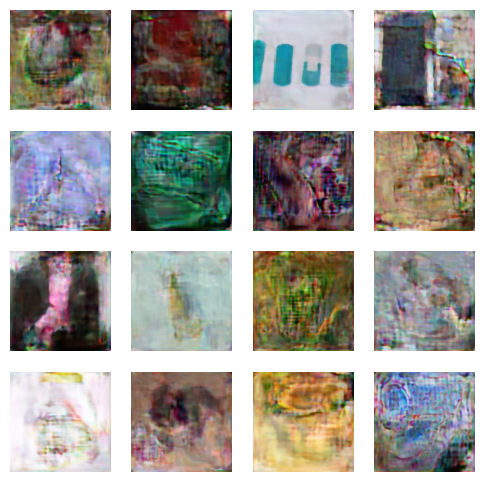

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

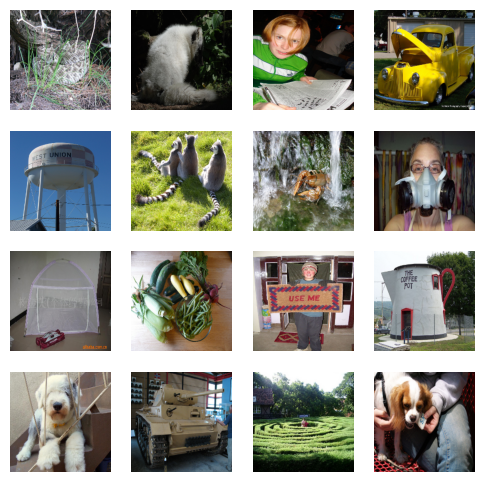

| It: 1 | Loss: -14.7445 | Time:   0.55s |


| It: 1001 | Loss: -58.8406 | Time: 451.15s |


| It: 2001 | Loss: -60.3672 | Time: 355.70s |


| It: 3001 | Loss: -60.9403 | Time: 356.49s |


| It: 4001 | Loss: -61.1835 | Time: 357.14s |


| It: 5001 | Loss: -61.3536 | Time: 356.32s |


| It: 6001 | Loss: -61.4856 | Time: 356.71s |


| It: 7001 | Loss: -61.5689 | Time: 356.96s |


| It: 8001 | Loss: -61.6212 | Time: 354.36s |


| It: 9001 | Loss: -61.6479 | Time: 356.47s |


| It: 1 | Loss: -6.7642 | Time:   0.36s |


| It: 1001 | Loss: -59.4425 | Time: 357.03s |


| It: 2001 | Loss: -60.7362 | Time: 356.41s |


| It: 3001 | Loss: -61.1399 | Time: 356.89s |


| It: 4001 | Loss: -61.3289 | Time: 349.53s |


| It: 5001 | Loss: -61.4497 | Time: 355.73s |


| It: 6001 | Loss: -61.5568 | Time: 357.00s |


| It: 7001 | Loss: -61.6214 | Time: 356.89s |


| It: 8001 | Loss: -61.6654 | Time: 350.94s |


| It: 9001 | Loss: -61.6880 | Time: 356.50s |


| It: 1 | Loss: -9.6425 | Time:   0.36s |


| It: 1001 | Loss: -58.3104 | Time: 353.84s |


| It: 2001 | Loss: -60.1080 | Time: 356.34s |


| It: 3001 | Loss: -60.7889 | Time: 356.24s |


| It: 4001 | Loss: -61.1196 | Time: 356.80s |


| It: 5001 | Loss: -61.3010 | Time: 356.76s |


| It: 6001 | Loss: -61.4323 | Time: 357.01s |


| It: 7001 | Loss: -61.5250 | Time: 355.87s |


| It: 8001 | Loss: -61.5782 | Time: 356.92s |


| It: 9001 | Loss: -61.6072 | Time: 356.38s |


| It: 1 | Loss: -3.9480 | Time:   0.35s |


| It: 1001 | Loss: -59.8068 | Time: 357.06s |


| It: 2001 | Loss: -60.9612 | Time: 356.49s |


| It: 3001 | Loss: -61.2864 | Time: 357.21s |


| It: 4001 | Loss: -61.4333 | Time: 356.86s |


| It: 5001 | Loss: -61.5381 | Time: 359.66s |


| It: 6001 | Loss: -61.6188 | Time: 357.64s |


| It: 7001 | Loss: -61.6709 | Time: 356.88s |


| It: 8001 | Loss: -61.7076 | Time: 355.54s |


| It: 9001 | Loss: -61.7265 | Time: 352.90s |


| It: 1 | Loss: -3.7792 | Time:   0.36s |


| It: 1001 | Loss: -59.2264 | Time: 355.78s |


| It: 2001 | Loss: -60.5523 | Time: 356.86s |


| It: 3001 | Loss: -60.9963 | Time: 355.98s |


| It: 4001 | Loss: -61.2762 | Time: 357.92s |


| It: 5001 | Loss: -61.4388 | Time: 356.37s |


| It: 6001 | Loss: -61.5452 | Time: 356.21s |


| It: 7001 | Loss: -61.6151 | Time: 356.34s |


| It: 8001 | Loss: -61.6597 | Time: 356.43s |


| It: 9001 | Loss: -61.6837 | Time: 356.73s |


BEST PSNR: 13.7491
MEDIAN PSNR: 13.4077
ALL PSNR: [13.3085, 13.6474, 12.8203, 13.7491, 13.7491]


<Figure size 400x300 with 0 Axes>

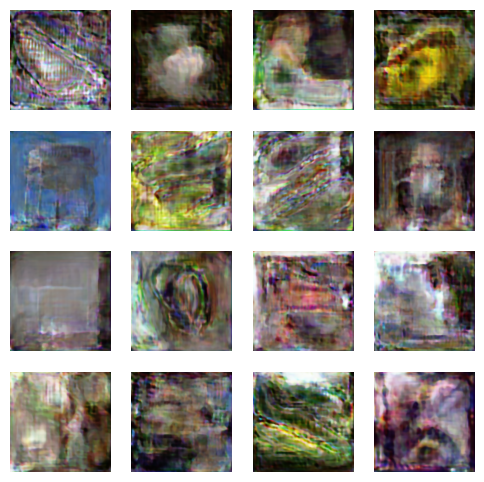

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

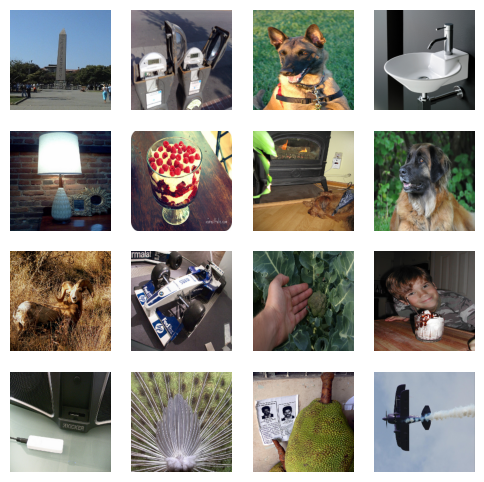

| It: 1 | Loss: -5.2527 | Time:   0.36s |


| It: 1001 | Loss: -59.8805 | Time: 355.91s |


| It: 2001 | Loss: -60.8083 | Time: 356.46s |


| It: 3001 | Loss: -61.1864 | Time: 354.53s |


| It: 4001 | Loss: -61.3916 | Time: 356.02s |


| It: 5001 | Loss: -61.5124 | Time: 352.53s |


| It: 6001 | Loss: -61.6076 | Time: 356.17s |


| It: 7001 | Loss: -61.6786 | Time: 354.79s |


| It: 8001 | Loss: -61.7210 | Time: 355.99s |


| It: 9001 | Loss: -61.7419 | Time: 356.11s |


| It: 1 | Loss: -8.9421 | Time:   0.36s |


| It: 1001 | Loss: -60.1330 | Time: 355.49s |


| It: 2001 | Loss: -61.1001 | Time: 356.78s |


| It: 3001 | Loss: -61.3600 | Time: 356.37s |


| It: 4001 | Loss: -61.5101 | Time: 356.92s |


| It: 5001 | Loss: -61.6187 | Time: 356.22s |


| It: 6001 | Loss: -61.6815 | Time: 352.79s |


| It: 7001 | Loss: -61.7294 | Time: 356.38s |


| It: 8001 | Loss: -61.7623 | Time: 356.29s |


| It: 9001 | Loss: -61.7786 | Time: 356.58s |


| It: 1 | Loss: -13.1885 | Time:   0.35s |


| It: 1001 | Loss: -59.6495 | Time: 356.78s |


| It: 2001 | Loss: -60.7737 | Time: 356.85s |


| It: 3001 | Loss: -61.2311 | Time: 356.88s |


| It: 4001 | Loss: -61.4289 | Time: 356.22s |


| It: 5001 | Loss: -61.5507 | Time: 356.30s |


| It: 6001 | Loss: -61.6420 | Time: 356.21s |


| It: 7001 | Loss: -61.7037 | Time: 356.35s |


| It: 8001 | Loss: -61.7396 | Time: 357.04s |


| It: 9001 | Loss: -61.7606 | Time: 356.84s |


| It: 1 | Loss: -15.2379 | Time:   0.36s |


| It: 1001 | Loss: -59.8503 | Time: 358.10s |


| It: 2001 | Loss: -60.8588 | Time: 358.57s |


| It: 3001 | Loss: -61.2565 | Time: 358.13s |


| It: 4001 | Loss: -61.4359 | Time: 351.33s |


| It: 5001 | Loss: -61.5644 | Time: 350.43s |


| It: 6001 | Loss: -61.6552 | Time: 356.50s |


| It: 7001 | Loss: -61.7154 | Time: 355.57s |


| It: 8001 | Loss: -61.7524 | Time: 356.67s |


| It: 9001 | Loss: -61.7697 | Time: 355.76s |


| It: 1 | Loss: -13.4367 | Time:   0.35s |


| It: 1001 | Loss: -59.6604 | Time: 357.83s |


| It: 2001 | Loss: -60.8171 | Time: 357.87s |


| It: 3001 | Loss: -61.2562 | Time: 357.84s |


| It: 4001 | Loss: -61.4532 | Time: 356.53s |


| It: 5001 | Loss: -61.5703 | Time: 358.96s |


| It: 6001 | Loss: -61.6524 | Time: 357.16s |


| It: 7001 | Loss: -61.7125 | Time: 358.40s |


| It: 8001 | Loss: -61.7466 | Time: 361.19s |


| It: 9001 | Loss: -61.7645 | Time: 358.77s |


BEST PSNR: 14.7707
MEDIAN PSNR: 13.9397
ALL PSNR: [13.5251, 13.5205, 14.7707, 14.1227, 14.1227]


<Figure size 400x300 with 0 Axes>

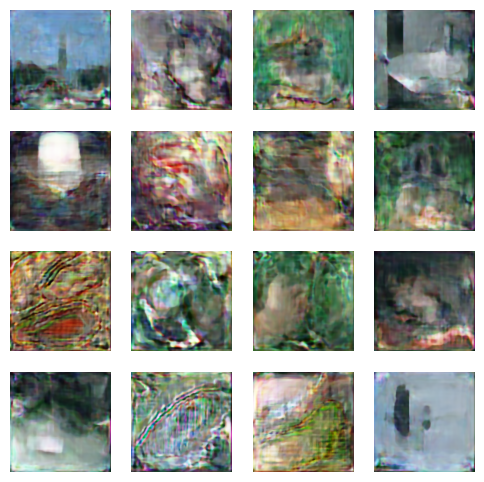

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

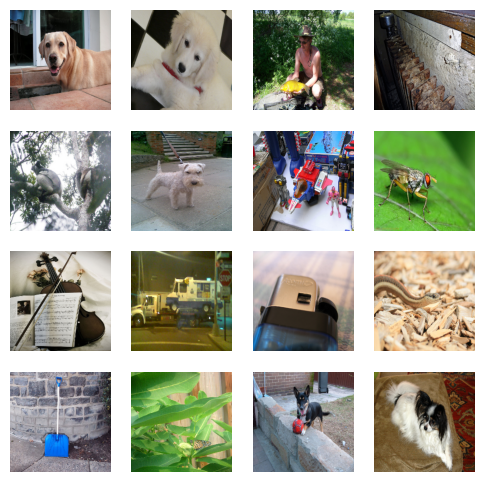

| It: 1 | Loss: -11.0536 | Time:   0.36s |


| It: 1001 | Loss: -60.1937 | Time: 352.73s |


| It: 2001 | Loss: -61.0744 | Time: 363.45s |


| It: 3001 | Loss: -61.3814 | Time: 364.70s |


| It: 4001 | Loss: -61.5117 | Time: 363.55s |


| It: 5001 | Loss: -61.6066 | Time: 361.86s |


| It: 6001 | Loss: -61.6778 | Time: 360.58s |


| It: 7001 | Loss: -61.7242 | Time: 363.46s |


| It: 8001 | Loss: -61.7582 | Time: 362.79s |


| It: 9001 | Loss: -61.7743 | Time: 364.44s |


| It: 1 | Loss: -21.4615 | Time:   0.37s |


| It: 1001 | Loss: -59.7307 | Time: 364.46s |


| It: 2001 | Loss: -60.8871 | Time: 363.30s |


| It: 3001 | Loss: -61.3011 | Time: 364.09s |


| It: 4001 | Loss: -61.4743 | Time: 379.86s |


| It: 5001 | Loss: -61.5859 | Time: 467.14s |


| It: 6001 | Loss: -61.6576 | Time: 467.52s |


| It: 7001 | Loss: -61.7167 | Time: 468.05s |


| It: 8001 | Loss: -61.7506 | Time: 466.23s |


| It: 9001 | Loss: -61.7681 | Time: 466.96s |


| It: 1 | Loss: -1.3168 | Time:   0.50s |


| It: 1001 | Loss: -60.3129 | Time: 467.27s |


| It: 2001 | Loss: -61.1702 | Time: 466.30s |


| It: 3001 | Loss: -61.4368 | Time: 465.36s |


| It: 4001 | Loss: -61.5636 | Time: 467.19s |


| It: 5001 | Loss: -61.6502 | Time: 464.11s |


| It: 6001 | Loss: -61.7072 | Time: 467.01s |


| It: 7001 | Loss: -61.7522 | Time: 465.88s |


| It: 8001 | Loss: -61.7806 | Time: 466.95s |


| It: 9001 | Loss: -61.7949 | Time: 466.20s |


| It: 1 | Loss: -5.0588 | Time:   0.50s |


| It: 1001 | Loss: -60.3899 | Time: 466.88s |


| It: 2001 | Loss: -61.1079 | Time: 466.16s |


| It: 3001 | Loss: -61.3842 | Time: 464.58s |


| It: 4001 | Loss: -61.5249 | Time: 463.87s |


| It: 5001 | Loss: -61.6058 | Time: 463.16s |


| It: 6001 | Loss: -61.6781 | Time: 465.76s |


| It: 7001 | Loss: -61.7247 | Time: 464.06s |


| It: 8001 | Loss: -61.7548 | Time: 465.17s |


| It: 9001 | Loss: -61.7728 | Time: 463.22s |


| It: 1 | Loss: -5.5191 | Time:   0.50s |


| It: 1001 | Loss: -60.4054 | Time: 466.44s |


| It: 2001 | Loss: -61.1510 | Time: 537.68s |


| It: 3001 | Loss: -61.4610 | Time: 567.20s |


| It: 4001 | Loss: -61.5840 | Time: 567.22s |


| It: 5001 | Loss: -61.6550 | Time: 566.90s |


| It: 6001 | Loss: -61.7172 | Time: 567.06s |


| It: 7001 | Loss: -61.7600 | Time: 566.35s |


| It: 8001 | Loss: -61.7868 | Time: 566.80s |


| It: 9001 | Loss: -61.8019 | Time: 566.24s |


BEST PSNR: 14.7067
MEDIAN PSNR: 14.5540
ALL PSNR: [14.5251, 14.3282, 14.6500, 14.5600, 14.5600]


<Figure size 400x300 with 0 Axes>

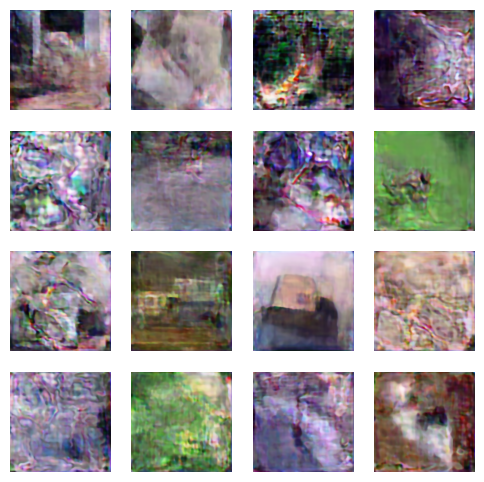

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

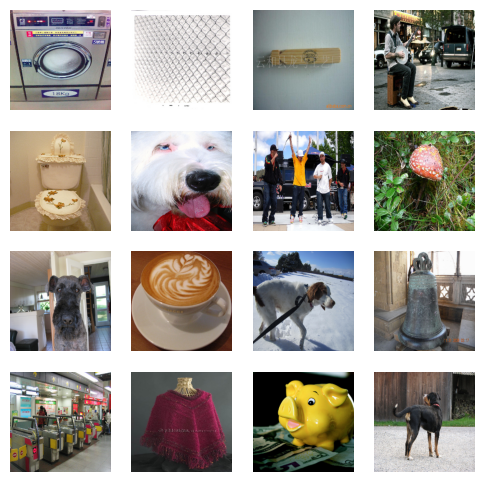

| It: 1 | Loss: -12.3611 | Time:   0.67s |


| It: 1001 | Loss: -60.1860 | Time: 566.57s |


| It: 2001 | Loss: -61.0487 | Time: 566.95s |


| It: 3001 | Loss: -61.3694 | Time: 566.67s |


| It: 4001 | Loss: -61.5278 | Time: 565.69s |


| It: 5001 | Loss: -61.6289 | Time: 566.66s |


| It: 6001 | Loss: -61.6948 | Time: 565.12s |


| It: 7001 | Loss: -61.7477 | Time: 565.77s |


| It: 8001 | Loss: -61.7789 | Time: 564.74s |


| It: 9001 | Loss: -61.7943 | Time: 566.50s |


| It: 1 | Loss: -10.9038 | Time:   0.56s |


| It: 1001 | Loss: -60.5697 | Time: 565.82s |


| It: 2001 | Loss: -61.1404 | Time: 566.10s |


| It: 3001 | Loss: -61.3914 | Time: 566.87s |


| It: 4001 | Loss: -61.5536 | Time: 567.63s |


| It: 5001 | Loss: -61.6426 | Time: 566.88s |


| It: 6001 | Loss: -61.7152 | Time: 564.81s |


| It: 7001 | Loss: -61.7644 | Time: 566.28s |


| It: 8001 | Loss: -61.7944 | Time: 567.32s |


| It: 9001 | Loss: -61.8093 | Time: 566.79s |


| It: 1 | Loss: -12.4072 | Time:   0.57s |


| It: 1001 | Loss: -60.2350 | Time: 566.53s |


| It: 2001 | Loss: -60.9343 | Time: 564.61s |


| It: 3001 | Loss: -61.2756 | Time: 565.14s |


| It: 4001 | Loss: -61.4655 | Time: 566.02s |


| It: 5001 | Loss: -61.5855 | Time: 565.78s |


| It: 6001 | Loss: -61.6687 | Time: 566.93s |


| It: 7001 | Loss: -61.7196 | Time: 565.12s |


| It: 8001 | Loss: -61.7594 | Time: 564.57s |


| It: 9001 | Loss: -61.7781 | Time: 566.28s |


| It: 1 | Loss: -10.7642 | Time:   0.55s |


| It: 1001 | Loss: -60.1006 | Time: 566.58s |


| It: 2001 | Loss: -60.9725 | Time: 563.60s |


| It: 3001 | Loss: -61.3539 | Time: 564.35s |


| It: 4001 | Loss: -61.5230 | Time: 565.19s |


| It: 5001 | Loss: -61.6391 | Time: 564.84s |


| It: 6001 | Loss: -61.7024 | Time: 566.77s |


| It: 7001 | Loss: -61.7557 | Time: 565.63s |


| It: 8001 | Loss: -61.7849 | Time: 563.26s |


| It: 9001 | Loss: -61.8006 | Time: 564.67s |


| It: 1 | Loss: -8.7955 | Time:   0.54s |


| It: 1001 | Loss: -59.6984 | Time: 564.24s |


| It: 2001 | Loss: -60.7753 | Time: 562.74s |


| It: 3001 | Loss: -61.2164 | Time: 565.47s |


| It: 4001 | Loss: -61.4398 | Time: 566.10s |


| It: 5001 | Loss: -61.5696 | Time: 566.31s |


| It: 6001 | Loss: -61.6587 | Time: 565.69s |


| It: 7001 | Loss: -61.7164 | Time: 565.87s |


| It: 8001 | Loss: -61.7528 | Time: 566.36s |


| It: 9001 | Loss: -61.7705 | Time: 564.00s |


BEST PSNR: 13.9320
MEDIAN PSNR: 13.7919
ALL PSNR: [13.7222, 13.7293, 13.7507, 13.9320, 13.9320]


<Figure size 400x300 with 0 Axes>

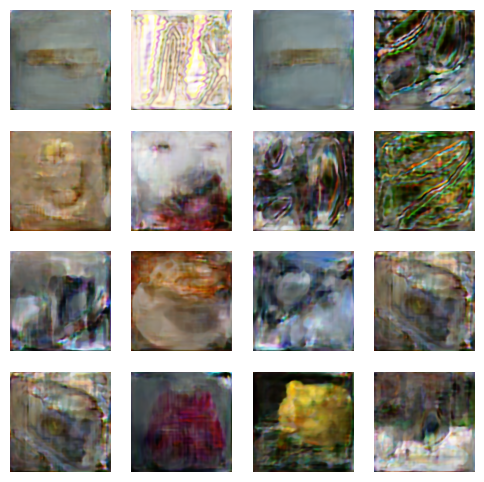

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)